# Descriptive Analysis

In [1]:
"""
Author: Surabhi S Nath
Description: This script implements descriptive analysis on the data.
"""

'\nAuthor: Surabhi S Nath\nDescription: This script implements descriptive analysis on the data.\n'

In [2]:
# Imports
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 10000)
%matplotlib inline
import seaborn as sns
sns.set_theme()
# sns.set(font_scale=1.5, font="serif")
sns.set(font_scale=1.8, font="serif", rc={'axes.facecolor':'white'})
from scipy import stats

In [3]:
def pearsonr_ci(x, y, alpha=0.05):
    """ 
    Calculate Pearson correlation along with the confidence interval using scipy and numpy
    
    Parameters:
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    
    Returns:
      r : float
        Pearson's correlation coefficient
      pval : float
        The corresponding p value
      lo, hi : float
        The lower and upper bound of confidence intervals
      df: integer
        Degrees of freedom
    """
    
    assert len(x) == len(y)

    df = len(x) - 2
    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi, df

In [4]:
# Define variables
path = "../data/"
patterns_path = "../"
num_patterns = 216

# Load files
pattern_to_num = pickle.load(open("utils/pattern_to_num.pk", 'rb'))
num_to_pattern = {v: k for k, v in pattern_to_num.items()}
info = pd.read_csv(path + "info.csv")
num_rows = info.shape[0]
pattern_stats = pd.read_csv("utils/pattern_stats.csv")
stat_analysis_csv = pd.read_csv("utils/stat_analysis.csv")

In [25]:
num_to_pattern[172]

'patterns/15by15/experiment/set4/SC0.677_symm0.00_KC251.2_5neigh_tot_code24_IC3_iter35.png'

## Filter Participants

In [ ]:
# Remove subjects who failed all attention checks
all_attention_failed = list(info[info["num_failed_attention_checks"] == info["num_attention_checks"]]["subject"])
num_participants = len(info[~info["subject"].isin(all_attention_failed)])
subjects = info[~info["subject"].isin(all_attention_failed)]["subject"].tolist()

In [ ]:
# Read data and save to arrays
pattern_complexity_ratings = [[] for i in range(num_patterns)]
pattern_beauty_ratings = [[] for i in range(num_patterns)]
subject_complexity_responses = []
subject_beauty_responses = []
subject_patterns = []

# save repeats info
repeats_complexity = []
repeats_beauty = []
participant_repeats_complexity_sd = []
participant_repeats_beauty_sd = []
repeats_distances = []
repeats1_complexity = []
repeats2_complexity = []
repeats1_beauty = []
repeats2_beauty = []

rtmean = np.zeros(100)

for i, file in enumerate(np.sort(os.listdir(path))):
    if file[0:4] != "data":
        continue
    if file[5:13] in all_attention_failed:
        continue
    
    csv = pd.read_csv(path + file)

    # Repeats
    repeats = csv[csv["is_repeated"] == True]
    tc = repeats.sort_values(by='pattern')["complexity_response"].to_numpy()
    tb = repeats.sort_values(by='pattern')["beauty_response"].to_numpy()
    repeats1_complexity.append(tc[::2])
    repeats2_complexity.append(tc[1::2])
    repeats1_beauty.append(tb[::2])
    repeats2_beauty.append(tb[1::2])
    participant_repeats_complexity_sd.append(np.mean(repeats.groupby('pattern').std()['complexity_response'].values))
    participant_repeats_beauty_sd.append(np.mean(repeats.groupby('pattern').std()['beauty_response'].values))
    repeats = repeats.sort_values(by='pattern').diff()
    repeats = repeats[repeats['pattern'] == 0]
    repeats_complexity.append(repeats['complexity_response'].abs().to_numpy())
    repeats_beauty.append(repeats['beauty_response'].abs().to_numpy())
    repeats_distances.append(repeats['trial'].abs().to_numpy())

    # Record responses and pattern list
    beauty_responses = csv["beauty_response"].to_numpy()
    subject_beauty_responses.append(beauty_responses)
    complexity_responses = csv["complexity_response"].to_numpy()
    subject_complexity_responses.append(complexity_responses)
    patterns = csv["pattern"].to_numpy()
    subject_patterns.append(patterns)
    
    # Record responses per pattern
    for i,p in enumerate(patterns):
        pattern_complexity_ratings[p-1].append(complexity_responses[i])
        pattern_beauty_ratings[p-1].append(beauty_responses[i])

## Correlations

In [ ]:
df_corr = pd.DataFrame(columns=["complexity_rating", "beauty_ratings", "density", "entropy", "mean_entropy", "entropy_of_means", "LSC", "KC", "intricacy_4", "intricacy_8", "local_asymm",	"Hasymm",	"Vasymm", "quadtree", "num_active_rules"])

rowid = 0

for r in range(len(subject_complexity_responses)):
    for i in range(len(subject_complexity_responses[r])):
        towrite = [float(subject_complexity_responses[r][i]), float(subject_beauty_responses[r][i])]
        towrite.extend([float(val) for val in pattern_stats[pattern_stats["patternnum"] == subject_patterns[r][i]][["density", "entropy", "mean_entropy", "entropy_of_means", "LSC", "KC", "intricacy_4", "intricacy_8", "local_asymm",	"Hasymm",	"Vasymm", "quadtree", "num_active_rules"]].values[0]])
        df_corr.loc[rowid] = towrite
        rowid += 1

# Uncomment to print significances, CI:
'''
for c1 in df_corr.columns:
    for c2 in df_corr.columns:
        print(c1, "\t", c2)
        corr, sig, cil, cih, df = pearsonr_ci(df_corr[c1].values, df_corr[c2].values)
        print(np.round(corr,2), "\t", np.round(sig, 3), "\t", np.round(cil, 2), "\t", np.round(cih, 2))
'''


df_corr = df_corr.rename(columns={"complexity_rating": "complexity rating",
                                                    "beauty_ratings": "beauty rating",
                                                    "mean_entropy": "mean entropy",
                                                    "entropy_of_means": "entropy of means",
                                                    "intricacy_4": "intricacy",
                                                    "local_asymm": "local asymmetry",
                                                    "Hasymm": "horizontal asymmetry",
                                                    "Vasymm": "vertical asymmetry",
                                                    "num_active_rules": "\u03BB"
                                                    })
df_corr = df_corr.corr(method='pearson').round(decimals=2)

# Figure 4
df_corr_measures = df_corr.drop(columns=['complexity rating', 'beauty rating', 'intricacy_8', 'quadtree'])
df_corr_measures = df_corr_measures.drop(['complexity rating', 'beauty rating', 'intricacy_8', 'quadtree'])
plt.figure(figsize=(16,10))
matrix = np.triu(df_corr_measures)
ax = sns.heatmap(df_corr_measures, annot=True, fmt=".2f", cmap="hot_r", mask=matrix)
plt.tight_layout()
plt.savefig("graphics/figures/Figure_4_correlations.png")

# Figure AIII.1
df_corr_ratings = df_corr.drop(columns=["density", "entropy", "mean entropy", "entropy of means", "LSC", "KC", "intricacy", "intricacy_8", "local asymmetry", "horizontal asymmetry", "vertical asymmetry", "quadtree", "λ"])
plt.figure(figsize=(12,7))
ax = sns.heatmap(df_corr_ratings, annot=True, fmt=".2f", cmap="hot_r")
plt.tight_layout()
plt.savefig("graphics/figures/Figure_AIII_1_correlations.png")

## Participant Qualitative Open-ended answers

In [ ]:
info["complexity_strategy"].tolist()        # responses for complexity rating strategy

In [ ]:
info["beauty_strategy"].tolist()            # responses for beauty rating strategy

In [ ]:
info["most_complex"].tolist()               # responses for most complex pattern

In [ ]:
info["most_beautiful"].tolist()             # responses for most beautiful pattern

## Average Ratings Analysis

### Average Beauty vs Average Complexity Plot

In [ ]:
stat_analysis_csv_patternwisemean = stat_analysis_csv.groupby("pattern").mean()
bins_entropy = [0, np.sort(stat_analysis_csv_patternwisemean["entropy"])[num_patterns//3], np.sort(stat_analysis_csv_patternwisemean["entropy"])[(num_patterns//3) * 2], np.inf]
names_entropy = ['low', 'medium', 'high']

stat_analysis_csv_patternwisemean["entropy bin"] = pd.cut(stat_analysis_csv_patternwisemean["entropy"], bins_entropy, labels=names_entropy)

def get_symm_bin(row):
    if row["Hasymm"] + row["Vasymm"] == 0:
        return "full symmetry"
    if row["Hasymm"] * row["Vasymm"] == 0:
        return "unidirection symmetry"
    return "partial/full asymmetry"

stat_analysis_csv_patternwisemean["symmetry bin"] = stat_analysis_csv_patternwisemean.apply(lambda row: get_symm_bin(row), axis=1)

# Figure AIII.3(a)
sns.scatterplot(data=stat_analysis_csv_patternwisemean, x='complexity_rating', y='beauty_rating', hue='symmetry bin')
plt.xlabel("Average Complexity Ratings")
plt.ylabel("Average Beauty Ratings")
sns.set(font_scale=1.5, font="serif")
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Figure AIII.3(b)
sns.scatterplot(data=stat_analysis_csv_patternwisemean, x='complexity_rating', y='beauty_rating', hue='entropy bin')
plt.xlabel("Average Complexity Ratings")
plt.ylabel("Average Beauty Ratings")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### GMM Analysis on Average ratings

In [ ]:
# Figure AIII.4

from sklearn.model_selection import train_test_split
import gmr
from gmr import GMM

X = stat_analysis_csv_patternwisemean["complexity_rating"].values.reshape(-1, 1)
X_test = X[:40,:]
X_train = X[40:,:]
y = stat_analysis_csv_patternwisemean["beauty_rating"].values.reshape(-1, 1)
y_test = y[:40,:]
y_train = y[40:,:]

data = np.concatenate([X_train, y_train], 1)

gmm = GMM(n_components=2, random_state=0)
gmm.from_samples(data)

data = np.linspace(np.min(y_train), np.max(y_train), 1000).reshape(-1, 1)
preds1 = gmm.predict([1], data)

preds2 = gmm.predict([1], y_test)
RMSE = np.sqrt(np.sum((preds2 - X_test)**2)/len(preds2))
print(RMSE)

sns.scatterplot(data=stat_analysis_csv_patternwisemean, x='complexity_rating', y='beauty_rating', hue='symmetry bin')
plt.plot(preds1, data, c = "black", linestyle='dashed')
plt.xlabel("Average Complexity Ratings")
plt.ylabel("Average Beauty Ratings")
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Filter Participants

In [ ]:
# Average attention check average failure
all_attention_failed = list(info[info["num_failed_attention_checks"] == info["num_attention_checks"]]["subject"])
num_participants = len(info[~info["subject"].isin(all_attention_failed)])
subjects = info[~info["subject"].isin(all_attention_failed)]["subject"].tolist()

In [ ]:
# Read data and save to arrays

pattern_complexity_ratings = [[] for i in range(num_patterns)]
pattern_beauty_ratings = [[] for i in range(num_patterns)]

subject_complexity_responses = []
subject_beauty_responses = []
subject_patterns = []

repeats_complexity = []
participant_repeats_complexity_sd = []
participant_repeats_beauty_sd = []
repeats_beauty = []
repeats_distances = []

# rest retest correlations
repeats1_complexity = []
repeats2_complexity = []
repeats1_beauty = []
repeats2_beauty = []

rtmean = np.zeros(100)

for i, file in enumerate(np.sort(os.listdir(path))):
    if file[0:4] != "data":
        continue
    if file[5:13] in all_attention_failed:
        continue
    
    csv = pd.read_csv(path + file)

    # Repeats
    repeats = csv[csv["is_repeated"] == True]
    tc = repeats.sort_values(by='pattern')["complexity_response"].to_numpy()
    tb = repeats.sort_values(by='pattern')["beauty_response"].to_numpy()
    repeats1_complexity.append(tc[::2])
    repeats2_complexity.append(tc[1::2])
    repeats1_beauty.append(tb[::2])
    repeats2_beauty.append(tb[1::2])
    participant_repeats_complexity_sd.append(np.mean(repeats.groupby('pattern').std()['complexity_response'].values))
    participant_repeats_beauty_sd.append(np.mean(repeats.groupby('pattern').std()['beauty_response'].values))
    repeats = repeats.sort_values(by='pattern').diff()
    repeats = repeats[repeats['pattern'] == 0]
    repeats_complexity.append(repeats['complexity_response'].abs().to_numpy())
    repeats_beauty.append(repeats['beauty_response'].abs().to_numpy())
    repeats_distances.append(repeats['trial'].abs().to_numpy())

    # Record responses and pattern list
    beauty_responses = csv["beauty_response"].to_numpy()
    subject_beauty_responses.append(beauty_responses)
    complexity_responses = csv["complexity_response"].to_numpy()
    subject_complexity_responses.append(complexity_responses)
    patterns = csv["pattern"].to_numpy()
    subject_patterns.append(patterns)
    
    # Record responses per pattern
    for i,p in enumerate(patterns):
        pattern_complexity_ratings[p-1].append(complexity_responses[i])
        pattern_beauty_ratings[p-1].append(beauty_responses[i])

## Consistency of Repeats 

In [ ]:
# Figure AIII.2(a)

plt.figure(figsize=(8,5))
plt.hist(participant_repeats_complexity_sd)
plt.xlabel("\nAverage Standard Deviation of Repeats")
plt.ylabel("Number of Participants\n")
plt.title("Complexity Ratings")
plt.tight_layout()
# plt.savefig("repeats.png")

In [ ]:
# Figure AIII.2(b)

plt.figure(figsize=(8,5))
plt.hist(participant_repeats_beauty_sd)
plt.xlabel("\nAverage Standard Deviation of Repeats")
plt.ylabel("Number of Participants\n")
plt.title("Beauty Ratings")
plt.tight_layout()

In [ ]:
repeats1_complexity = np.array(repeats1_complexity)
repeats2_complexity = np.array(repeats2_complexity)
repeats1_beauty = np.array(repeats1_beauty)
repeats2_beauty = np.array(repeats2_beauty)

In [ ]:
avg_ppt_corr_complexity = 0
avg_ppt_corr_complexities = []
for pair in zip(repeats1_complexity, repeats2_complexity):
    # print(pearsonr_ci(pair[0], pair[1]))
    avg_ppt_corr_complexity += np.corrcoef(pair[0], pair[1])[0,1]
    avg_ppt_corr_complexities.append(np.corrcoef(pair[0], pair[1])[0,1])
print(avg_ppt_corr_complexity/len(repeats1_complexity))

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(avg_ppt_corr_complexities)
plt.xlabel("\nTest-retest Correlation")
plt.ylabel("Number of Participants\n")
plt.title("Complexity Ratings")
plt.tight_layout()

In [ ]:
avg_ppt_corr_beauty = 0
avg_ppt_corr_beauties = []
for pair in zip(repeats1_beauty, repeats2_beauty):
    avg_ppt_corr_beauty += np.corrcoef(pair[0], pair[1])[0,1]
    avg_ppt_corr_beauties.append(np.corrcoef(pair[0], pair[1])[0,1])
print(avg_ppt_corr_beauty/len(repeats1_beauty))

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(avg_ppt_corr_beauties)
plt.xlabel("\nTest-retest Correlation")
plt.ylabel("Number of Participants\n")
plt.title("Beauty Ratings")
plt.tight_layout()

In [ ]:
assert(len(repeats1_complexity) == len(repeats2_complexity))
assert(len(repeats1_beauty) == len(repeats2_beauty))

print(np.corrcoef(repeats1_complexity.flatten(), repeats2_complexity.flatten())[0,1])
print(np.corrcoef(repeats1_beauty.flatten(), repeats2_beauty.flatten())[0,1])

In [ ]:
assert(len(repeats_complexity) == len(repeats_beauty) == len(repeats_distances) == num_participants)
assert(len(subject_patterns) == len(subject_complexity_responses) == len(subject_beauty_responses) == num_participants)

## Correlations

In [ ]:
# df_corr = pd.DataFrame(columns=["complexity_rating", "beauty_ratings", "LSC", "KC", "local_asymm",	"Hasymm",	"Vasymm", "entropy", "mean_entropy", "entropy_of_means", "density", "intricacy_4", "intricacy_8", "quadtree", "num_active_rules"])
df_corr = pd.DataFrame(columns=["complexity_rating", "beauty_ratings", "density", "entropy", "mean_entropy", "entropy_of_means", "LSC", "KC", "intricacy_4", "intricacy_8", "local_asymm",	"Hasymm",	"Vasymm", "quadtree", "num_active_rules"])

rowid = 0

for r in range(len(subject_complexity_responses)):
    for i in range(len(subject_complexity_responses[r])):
        towrite = [float(subject_complexity_responses[r][i]), float(subject_beauty_responses[r][i])]
        towrite.extend([float(val) for val in pattern_stats[pattern_stats["patternnum"] == subject_patterns[r][i]][["density", "entropy", "mean_entropy", "entropy_of_means", "LSC", "KC", "intricacy_4", "intricacy_8", "local_asymm",	"Hasymm",	"Vasymm", "quadtree", "num_active_rules"]].values[0]])
        df_corr.loc[rowid] = towrite
        rowid += 1

In [ ]:
for c1 in df_corr.columns:
    for c2 in df_corr.columns:
        print(c1, "\t", c2)
        corr, sig, cil, cih, df = pearsonr_ci(df_corr[c1].values, df_corr[c2].values)
        print(np.round(corr,2), "\t", np.round(sig, 3), "\t", np.round(cil, 2), "\t", np.round(cih, 2))

In [ ]:
df_corr = df_corr.rename(columns={"complexity_rating": "complexity rating",
                                                    "beauty_ratings": "beauty rating",
                                                    "SC": "LSC",
                                                    "local_asymm": "local asymmetry",
                                                    "Hasymm": "horizontal asymmetry",
                                                    "Vasymm": "vertical asymmetry",
                                                    "num_active_rules": "\u03BB"
                                                    })
df_corr = df_corr.corr(method='pearson').round(decimals=2)

df_corr_measures = df_corr.drop(columns=['complexity rating', 'beauty rating', 'intricacy_8', 'quadtree'])
df_corr_measures = df_corr_measures.drop(['complexity rating', 'beauty rating', 'intricacy_8', 'quadtree'])
df_corr_ratings = df_corr.drop(columns=['LSC', 'KC', 'local asymmetry', 'horizontal asymmetry', 'vertical asymmetry', 'entropy_of_means', 'density', 'intricacy_4', 'intricacy_8', 'quadtree', 'λ'])

In [ ]:
# Figure 4

plt.figure(figsize=(16,10))
matrix = np.triu(df_corr_measures)
ax = sns.heatmap(df_corr_measures, annot=True, fmt=".2f", cmap="hot_r", mask=matrix)
plt.tight_layout()
sns.set(font_scale=2, font="serif", rc={'axes.facecolor':'white'})

In [ ]:
# Figure AIII.1

plt.figure(figsize=(12,7))
ax = sns.heatmap(df_corr_ratings, annot=True, fmt=".2f", cmap="hot_r")
plt.tight_layout()

In [ ]:
subject_beauty_responses = np.array(subject_beauty_responses)
subject_beauty_responses_binned = np.reshape(np.sort(subject_beauty_responses.reshape(subject_beauty_responses.shape[0] * subject_beauty_responses.shape[1])), (10, -1))

In [29]:
num_to_pattern[18]

'patterns/15by15/experiment/set1/SC0.804_symm0.00_KC195.1_5neigh_outertot_code461_IC1_iter05.png'

## Max Discrepancy

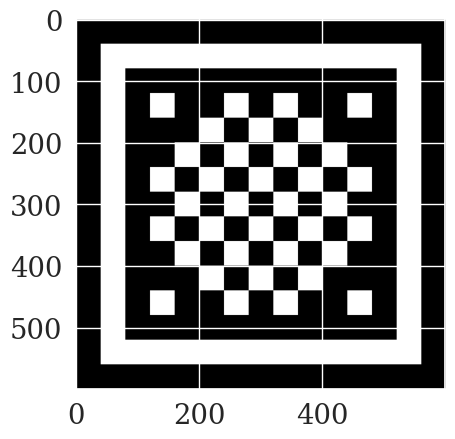

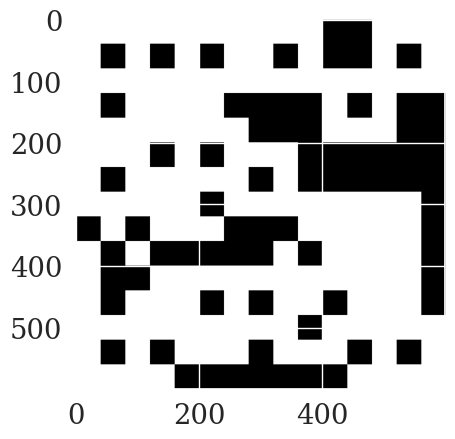

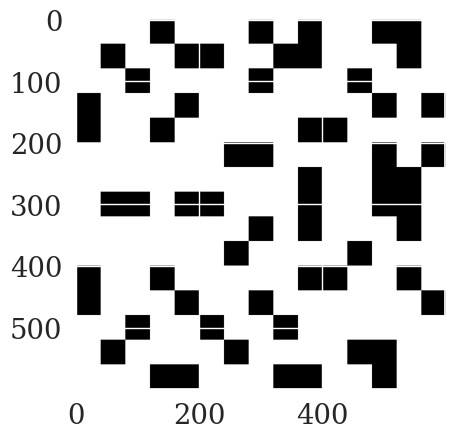

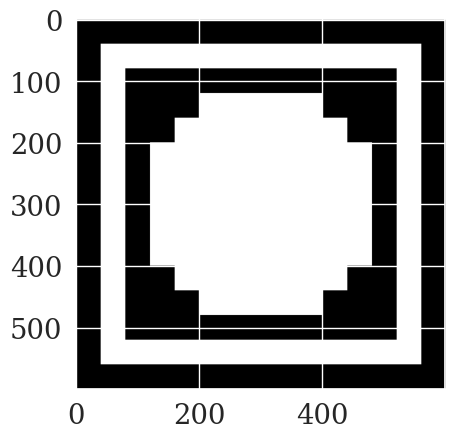

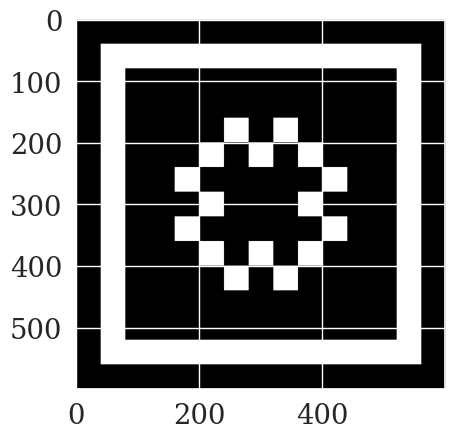

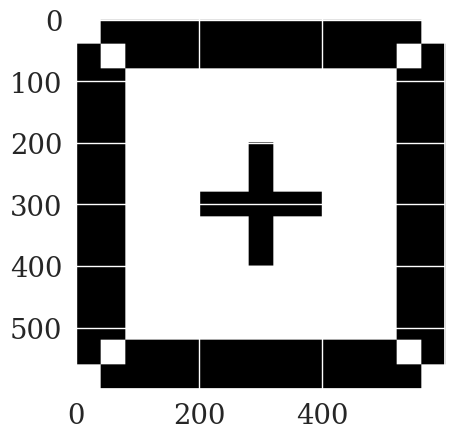

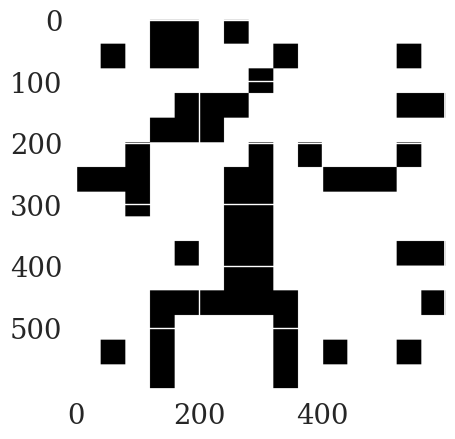

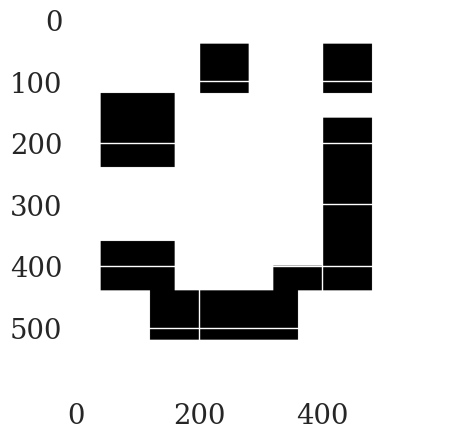

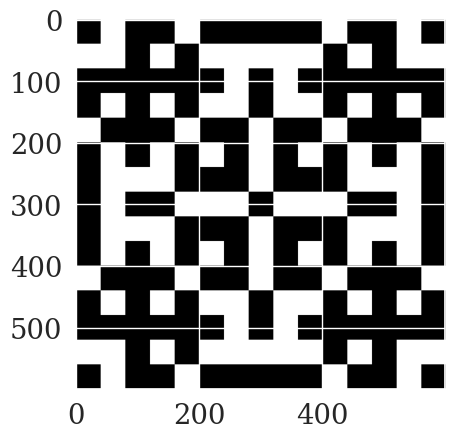

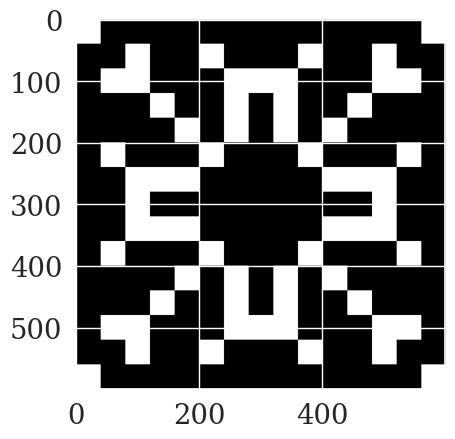

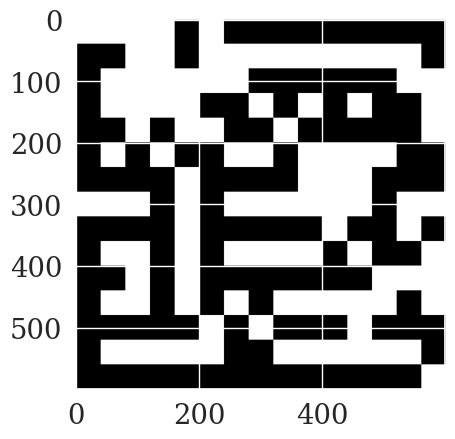

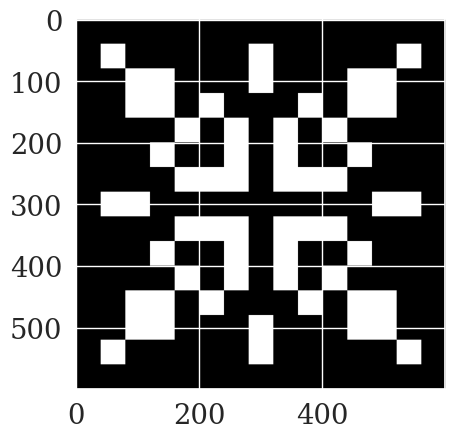

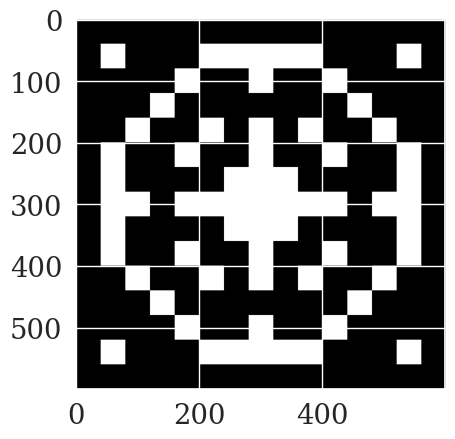

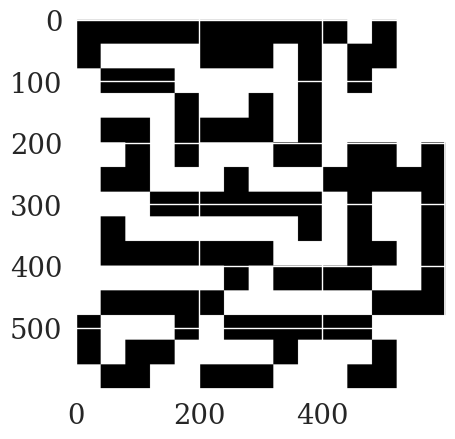

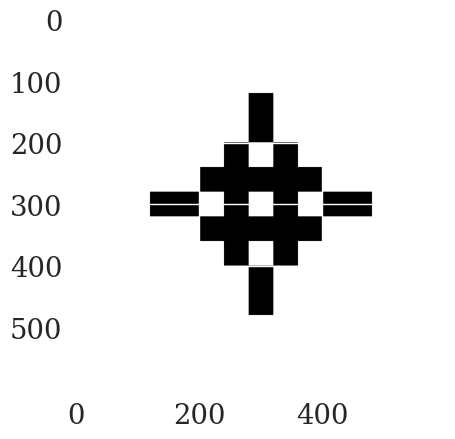

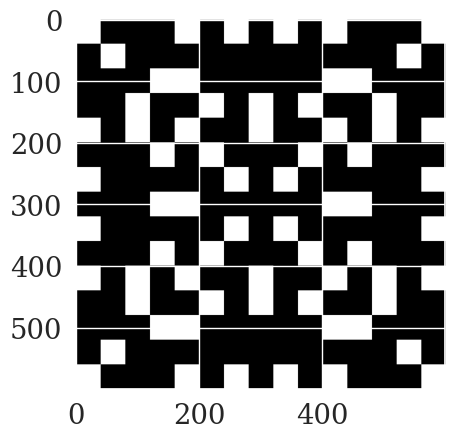

In [26]:
# Figure 8

max_discrepancy_pattnnums = [92, 195, 22, 194, 81, 71, 180, 172, 207, 190, 204, 140, 143, 203, 166, 23]
max_discrepancy_patterns = np.vectorize(num_to_pattern.get)(max_discrepancy_pattnnums)
for pattern in max_discrepancy_patterns:
    image = plt.imread(patterns_path + pattern)
    plt.imshow(image)
    plt.show()

## Perceived Complexity vs Complexity Measure

In [ ]:
for ind in range(num_participants):
    SCs = []
    intricacies = []
    for patt in subject_patterns[ind]:
        spatcomp = pattern_stats[pattern_stats["patternnum"] == patt]["SC"].item()
        SCs.append(spatcomp)
        intricacy = pattern_stats[pattern_stats["patternnum"] == patt]["intricacy_4"].item()
        intricacies.append(intricacy)
        #tot_outertot = pattern_stats[pattern_stats["pattern"] == patt]["tot_outertot"].item()
    SCs = np.array(SCs)
    intricacies = np.array(intricacies)
#     x = SCs * 100
    # x = 59.32648 * SCs + 0.29730 * intricacies -9.15071
    x = 57.67884 * SCs + 0.3055209 * intricacies - 9.125685
    plt.figure()
#     plt.scatter(complexity_responses, beauty_responses, label="Perceived Complexity")
#     plt.scatter(SC, beauty_responses, label="Spatial Complexity")
    CR = subject_complexity_responses[ind]
    plt.scatter(x, CR)
    plt.ylim(1,100)
    plt.xlabel("Complexity Measure")
    plt.ylabel("Perceived Complexity")
    m, b = np.polyfit(x, CR, 1)
    plt.plot(x, m*x + b, label = np.corrcoef(x, CR)[0,1])
    plt.legend(loc="upper left")

## Average Response

In [ ]:
avg_pattern_beauty_ratings = np.array([np.mean(l) for l in pattern_beauty_ratings])
avg_pattern_complexity_ratings = np.array([np.mean(l) for l in pattern_complexity_ratings])
std_pattern_complexity_ratings = np.array([np.std(l) for l in pattern_complexity_ratings])
assert(len(avg_pattern_beauty_ratings) == num_patterns)
assert(len(avg_pattern_complexity_ratings) == num_patterns)

In [ ]:
fully_symmetric_patterns = pattern_stats[(pattern_stats["Hasymm"] == 0) & (pattern_stats["Vasymm"] == 0)]["patternnum"].to_numpy() - 1
semi_symmetric_patterns = pattern_stats[((pattern_stats["Hasymm"] == 0) & (pattern_stats["Vasymm"] != 0)) | ((pattern_stats["Hasymm"] != 0) & (pattern_stats["Vasymm"] == 0))]["patternnum"].to_numpy() - 1
non_symmetric_patterns = pattern_stats[(pattern_stats["Hasymm"] != 0) & (pattern_stats["Vasymm"] != 0)]["patternnum"].to_numpy() - 1

In [ ]:
assert(len(fully_symmetric_patterns) + len(semi_symmetric_patterns) + len(non_symmetric_patterns) == num_patterns)

## Pattern Visualisation

In [ ]:
high_complex_patternnums = np.array([(i,v) for i,v in enumerate(avg_pattern_complexity_ratings) if v > 70])
high_complex_patterns = np.vectorize(num_to_pattern.get)(high_complex_patternnums[:,0] + 1)

low_complex_patternnums = np.array([(i,v) for i,v in enumerate(avg_pattern_complexity_ratings) if v < 17.8])
low_complex_patterns = np.vectorize(num_to_pattern.get)(low_complex_patternnums[:,0] + 1)

high_beauty_patternnums = np.array([(i,v) for i,v in enumerate(avg_pattern_beauty_ratings) if v > 70])
high_beauty_patterns = np.vectorize(num_to_pattern.get)(high_beauty_patternnums[:,0] + 1)

low_beauty_patternnums = np.array([(i,v) for i,v in enumerate(avg_pattern_beauty_ratings) if v < 20])
low_beauty_patterns = np.vectorize(num_to_pattern.get)(low_beauty_patternnums[:,0] + 1)

### High Complexity

In [ ]:
# Figure 5A
inds = np.argsort(high_complex_patternnums[:,1])
for i in range(len(high_complex_patterns)):
    print(high_complex_patternnums[inds[i]])
    print(np.mean(pattern_complexity_ratings[int(high_complex_patternnums[inds[i]][0])]), np.var(pattern_complexity_ratings[int(high_complex_patternnums[inds[i]][0])]))
    print(high_complex_patterns[inds[i]])
    image = plt.imread(patterns_path + high_complex_patterns[inds[i]])
    plt.imshow(image)
    plt.title(np.round(high_complex_patternnums[inds[i],1],2))
    plt.show()

### Low Complexity

In [ ]:
# Figure 5B
inds = np.argsort(low_complex_patternnums[:,1])
for i in range(len(low_complex_patterns)):
    print(low_complex_patternnums[inds[i]])
    print(np.mean(pattern_complexity_ratings[int(low_complex_patternnums[inds[i]][0])]), np.var(pattern_complexity_ratings[int(low_complex_patternnums[inds[i]][0])]))
    print(low_complex_patterns[inds[i]])
    image = plt.imread(patterns_path + low_complex_patterns[inds[i]])
    plt.imshow(image)
    plt.title(np.round(low_complex_patternnums[inds[i],1],2))
    plt.show()

### High Beauty

In [ ]:
# Figure 5C
inds = np.argsort(high_beauty_patternnums[:,1])
for i in range(len(high_beauty_patterns)):
    print(high_beauty_patternnums[inds[i]])
    print(np.mean(pattern_beauty_ratings[int(high_beauty_patternnums[inds[i]][0])]), np.var(pattern_beauty_ratings[int(high_beauty_patternnums[inds[i]][0])]))
    print(high_beauty_patterns[inds[i]])
    image = plt.imread(patterns_path + high_beauty_patterns[inds[i]])
    plt.imshow(image)
    plt.title(np.round(high_beauty_patternnums[inds[i],1],2))
    plt.show()

### Low Beauty

In [ ]:
# Figure 5D
inds = np.argsort(low_beauty_patternnums[:,1])
for i in range(len(low_beauty_patterns)):
    print(low_beauty_patternnums[inds[i]])
    print(np.mean(pattern_beauty_ratings[int(low_beauty_patternnums[inds[i]][0])]), np.var(pattern_beauty_ratings[int(low_beauty_patternnums[inds[i]][0])]))
    print(low_beauty_patterns[inds[i]])
    image = plt.imread(patterns_path + low_beauty_patterns[inds[i]])
    plt.imshow(image)
    plt.title(np.round(low_beauty_patternnums[inds[i],1],2))
    plt.show()

## Variance in Pattern Ratings

In [ ]:
var_pattern_complexity_ratings = [np.var(l) for l in pattern_complexity_ratings]
var_pattern_beauty_ratings = [np.var(l) for l in pattern_beauty_ratings]

In [ ]:
confusing_patternnums = np.array([(i,v) for i,v in enumerate(var_pattern_complexity_ratings) if v > 771])
confusing_patterns = np.vectorize(num_to_pattern.get)(confusing_patternnums[:,0] + 1)

consistent_patternnums = np.array([(i,v) for i,v in enumerate(var_pattern_complexity_ratings) if v < 170])
consistent_patterns = np.vectorize(num_to_pattern.get)(consistent_patternnums[:,0] + 1)

confusing_patternnums_beauty = np.array([(i,v) for i,v in enumerate(var_pattern_beauty_ratings) if v > 760])
confusing_patterns_beauty = np.vectorize(num_to_pattern.get)(confusing_patternnums_beauty[:,0] + 1)

consistent_patternnums_beauty = np.array([(i,v) for i,v in enumerate(var_pattern_beauty_ratings) if v < 190])
consistent_patterns_beauty = np.vectorize(num_to_pattern.get)(consistent_patternnums_beauty[:,0] + 1)

### Consistent Patterns Complexity

In [ ]:
# Figure 5E
inds = np.argsort(consistent_patternnums[:,1])
for i in range(len(consistent_patterns)):
    print(consistent_patternnums[inds[i]])
    print(np.mean(pattern_complexity_ratings[int(consistent_patternnums[inds[i]][0])]), np.var(pattern_complexity_ratings[int(consistent_patternnums[inds[i]][0])]))
    print(consistent_patterns[inds[i]])
    image = plt.imread(patterns_path + consistent_patterns[inds[i]])
    plt.imshow(image)
    plt.title(np.round(np.sqrt(consistent_patternnums[inds[i],1]), 2))
    plt.show()

### Confusing Patterns Complexity

In [ ]:
# Figure 5F
inds = np.argsort(confusing_patternnums[:,1])
for i in range(len(confusing_patterns)):
    print(confusing_patternnums[inds[i]])
    print(np.mean(pattern_complexity_ratings[int(confusing_patternnums[inds[i]][0])]), np.var(pattern_complexity_ratings[int(confusing_patternnums[inds[i]][0])]))
    print(confusing_patterns[inds[i]])
    image = plt.imread(patterns_path + confusing_patterns[inds[i]])
    plt.imshow(image)
    plt.title(np.round(np.sqrt(confusing_patternnums[inds[i],1]), 2))
    plt.show()

### Consistent Patterns Beauty

In [ ]:
# Figure 5G
inds = np.argsort(consistent_patternnums_beauty[:,1])
for i in range(len(consistent_patterns_beauty)):
    print(consistent_patternnums_beauty[inds[i]])
    print(np.mean(pattern_beauty_ratings[int(consistent_patternnums_beauty[inds[i]][0])]), np.var(pattern_beauty_ratings[int(consistent_patternnums_beauty[inds[i]][0])]))
    print(consistent_patterns_beauty[inds[i]])
    image = plt.imread(patterns_path + consistent_patterns_beauty[inds[i]])
    plt.imshow(image)
    plt.title(np.round(np.sqrt(consistent_patternnums_beauty[inds[i],1]), 2))
    plt.show()

### Confusing Patterns Beauty

In [ ]:
# Figure 5H
inds = np.argsort(confusing_patternnums_beauty[:,1])
for i in range(len(confusing_patterns_beauty)):
    print(confusing_patternnums_beauty[inds[i]])
    print(np.mean(pattern_beauty_ratings[int(confusing_patternnums_beauty[inds[i]][0])]), np.var(pattern_beauty_ratings[int(confusing_patternnums_beauty[inds[i]][0])]))
    print(confusing_patterns_beauty[inds[i]])
    image = plt.imread(patterns_path + confusing_patterns_beauty[inds[i]])
    plt.imshow(image)
    plt.title(np.round(np.sqrt(confusing_patternnums_beauty[inds[i],1]), 2))
    plt.show()